# Minimal Left Right Symmetric models with Higgs doublets

In this notebook we start to extract the feynman rules of the defined lagrangians

In [1]:
from sympy import init_printing, Mul, sin, cos, tan, factor
init_printing()

In [2]:
from potential_senjanovic_HiggsDoublets import change_scalar_fields, vev_physical_charged_scalars
from potential_senjanovic_HiggsDoublets import H10, H20, H30, H40, A10, A20, GZ1, GZ2, GLp
from potential_senjanovic_HiggsDoublets import k1, k2, vR, Phi, ChiL, ChiR, complex_scalar_fields
from Gauge_Higgs_senjanovic_HiggsDoublets import change_neutral_bosons_R, change_charged_bosons
from Gauge_Higgs_senjanovic_HiggsDoublets import W1p, W2p, W1m, W2m, A, Z1, Z2, R13
from Gauge_Higgs_senjanovic_HiggsDoublets import partial_mu_Phi, partial_mu_L, partial_mu_R, partial_mu
from Gauge_Higgs_senjanovic_HiggsDoublets import LHiggs_physical, xi, zeta, tan2xi_sol, tan2zeta_sol_approx


In [3]:
from symbolic_tools import find_feynman_coefficients2

In [4]:
find_feynman_coefficients = lambda Lag, fields, parameters: find_feynman_coefficients2(
    Lag, fields, parameters, D=partial_mu
)

In [5]:
vev_physical_charged_scalars

In [13]:
from symbolic_tools import PartialMu, momentum
partial_mu_momentum = PartialMu

In [107]:
scalar_fields = list(vev_physical_charged_scalars.keys()) + [H10, H20, H30, H40, A10, A20,  GZ1, GZ2]
gauge_fields = [W1p, W2p, W1m, W2m, A, Z1, Z2]
scalar_fields_partial_mu = [partial_mu(scalar) for scalar in scalar_fields]
scalar_fields_momentum = [momentum(scalar) for scalar in scalar_fields]


fields = set(scalar_fields + scalar_fields_partial_mu + gauge_fields)

In [108]:
scalar_fields

In [109]:
scalar_fields_partial_mu

In [110]:
gauge_fields

In [111]:
fields

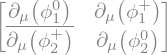

In [112]:
partial_mu_Phi

In [113]:
def D_linear(expr, fields=scalar_fields + gauge_fields):
    """Apply linearity and Leibniz rule to D."""
    expr = expr.expand()
    if expr.is_Add:
        return sum(D_linear(arg) for arg in expr.args)
    
    elif expr.is_Mul:
        # Factor out coefficients (extract terms that are not fields)
        factors = expr.as_ordered_factors()
        field_part = [f for f in factors if f in fields]
        coeff_part = [f for f in factors if f not in fields]
        
        if len(field_part) == 1:  # If there's exactly one field
            coeff = Mul(*coeff_part) if coeff_part else 1  # Handle case where coefficient is 1
            return coeff * partial_mu(field_part[0])  # Apply D only to the field
        else:
            # Apply Leibniz rule for multiple fields
            terms = []
            for i in range(len(field_part)):
                new_factors = field_part.copy()
                new_factors[i] = partial_mu(new_factors[i])  # Apply D to one field
                terms.append(Mul(*coeff_part, *new_factors))
            return sum(terms)
    
    elif expr in fields:  # If it's a field, apply D
        return partial_mu(expr)
    
    else:
        return expr  # Constants remain unchanged

# Test example
expr1 = k1 * H10 + k2 * H20  # Linear combination of fields

# Apply D to expressions
D_expr1 = D_linear(expr1)

print("partial_mu applied to linear combination:")
display(D_expr1)


partial_mu applied to linear combination:


In [114]:
LHiggs_physical = LHiggs_physical.replace(partial_mu, D_linear).expand().replace(partial_mu, partial_mu_momentum).doit()

In [119]:
#parameters_ = (LHiggs_physical.free_symbols.union(LHiggs_physical.atoms(momentum))).difference(fields)
parameters_ = set(list((LHiggs_physical.free_symbols).difference(fields)) + scalar_fields_momentum)
parameters_

In [16]:
from sympy import Function

In [17]:
LHiggs_physical.atoms(partial_mu)

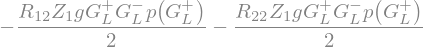

In [120]:
Ltest = (LHiggs_physical.expand().coeff(Z1).coeff(momentum(GLp))*Z1*momentum(GLp)).expand()
Ltest

In [121]:
from sympy import symbols, Symbol, Function, expand, Mul, collect

def extract_interaction_coefficients(L, fields, parameters):
    """
    Extracts interaction coefficients from a Lagrangian.

    Args:
        L (sympy expression): The Lagrangian containing fields and parameters.
        fields (iterable): A list or set of sympy symbols representing the fields.
        parameters (set): A set of sympy symbols and functions representing parameters.

    Returns:
        dict: A nested dictionary with:
            - Outer key: Number of interacting fields.
            - Inner key: Tuple of interacting fields (sorted).
            - Value: Coefficient of the interaction term.
    """
    # Ensure fields is a set of valid SymPy objects
    fields = {f for f in fields if isinstance(f, (Symbol, Function))}
    
    # Expand the Lagrangian
    L_expanded = expand(L)

    # Initialize the classification dictionary
    interaction_dict = {}

    # Iterate over each term in the expanded Lagrangian
    for term in L_expanded.as_ordered_terms():
        # Extract fields appearing in the term using `free_symbols`
        term_fields = sorted(
            [f for f in fields.intersection(term.free_symbols)],
            key=lambda x: str(x)  # Sort by string representation
        )

        term_fields = tuple(term_fields)  # Convert to tuple after sorting
        num_fields = len(term_fields)

        # Extract the coefficient by dividing the term by the product of detected fields
        field_product = Mul(*term_fields) if term_fields else 1  # Avoid empty product
        coefficient = term / field_product  # Divide out the fields to isolate the coefficient
        coefficient = coefficient.simplify()  # Ensure full simplification

        # Sum coefficients that belong to the same interaction (avoid missing R_{12})
        if num_fields not in interaction_dict:
            interaction_dict[num_fields] = {}

        if term_fields in interaction_dict[num_fields]:
            interaction_dict[num_fields][term_fields] += coefficient  # Sum contributions
        else:
            interaction_dict[num_fields][term_fields] = coefficient

    return interaction_dict


In [122]:
from sympy import symbols, Symbol, Function, expand, Mul, simplify

def extract_interaction_coefficients(L, fields, parameters):
    """
    Extracts interaction coefficients from a Lagrangian.

    Args:
        L (sympy expression): The Lagrangian containing fields and parameters.
        fields (iterable): A list or set of sympy symbols representing the fields.
        parameters (set): A set of sympy symbols and functions representing parameters.

    Returns:
        dict: A nested dictionary with:
            - Outer key: Number of interacting fields.
            - Inner key: Tuple of interacting fields (sorted).
            - Value: Coefficient of the interaction term.
    """
    # Ensure fields is a set of valid SymPy objects
    fields = {f for f in fields if isinstance(f, (Symbol, Function))}
    
    # Expand the Lagrangian
    L_expanded = expand(L)

    # Initialize the classification dictionary
    interaction_dict = {}

    # Iterate over each term in the expanded Lagrangian
    for term in L_expanded.as_ordered_terms():
        # Extract fields appearing in the term using `free_symbols`
        detected_fields = [f for f in fields if f in term.free_symbols]
        term_fields = tuple(sorted(detected_fields, key=lambda x: str(x)))

        num_fields = len(term_fields)

        # Extract the coefficient by dividing the term by the product of detected fields
        field_product = Mul(*term_fields) if term_fields else 1  # Avoid empty product
        coefficient = simplify(term / field_product)  # Divide and simplify

        # Store in dictionary
        if num_fields not in interaction_dict:
            interaction_dict[num_fields] = {}

        # Sum coefficients correctly for repeated field interactions
        if term_fields in interaction_dict[num_fields]:
            interaction_dict[num_fields][term_fields] += coefficient
        else:
            interaction_dict[num_fields][term_fields] = coefficient

    return interaction_dict


In [123]:
from sympy import symbols, Symbol, Function, expand, Mul, simplify, cancel

def extract_interaction_coefficients(L, fields, parameters):
    """
    Extracts interaction coefficients from a Lagrangian.

    Args:
        L (sympy expression): The Lagrangian containing fields and parameters.
        fields (iterable): A list or set of sympy symbols representing the fields.
        parameters (set): A set of sympy symbols and functions representing parameters.

    Returns:
        dict: A nested dictionary with:
            - Outer key: Number of interacting fields.
            - Inner key: Tuple of interacting fields (sorted).
            - Value: Coefficient of the interaction term.
    """
    # Ensure fields is a set of valid SymPy objects
    fields = {f for f in fields if isinstance(f, (Symbol, Function))}
    
    # Expand the Lagrangian
    L_expanded = expand(L)

    # Initialize the classification dictionary
    interaction_dict = {}

    # Iterate over each term in the expanded Lagrangian
    for term in L_expanded.as_ordered_terms():
        # Extract fields appearing in the term using free_symbols and functions
        detected_fields = [f for f in fields if any(sub in term.free_symbols for sub in f.atoms(Symbol))]
        term_fields = tuple(sorted(detected_fields, key=lambda x: str(x)))

        num_fields = len(term_fields)

        # Extract the coefficient by dividing the term by the product of detected fields
        field_product = Mul(*term_fields) if term_fields else 1  # Avoid empty product
        coefficient = cancel(term / field_product)  # Ensure full cancellation

        # Store in dictionary
        if num_fields not in interaction_dict:
            interaction_dict[num_fields] = {}

        # Sum coefficients correctly for repeated field interactions
        if term_fields in interaction_dict[num_fields]:
            interaction_dict[num_fields][term_fields] += coefficient
        else:
            interaction_dict[num_fields][term_fields] = coefficient

    return interaction_dict

In [141]:
from sympy import symbols, Symbol, Function, expand, Mul, Pow, simplify, cancel

def extract_interaction_coefficients(L, fields, parameters):
    """
    Extracts interaction coefficients from a Lagrangian.

    Args:
        L (sympy expression): The Lagrangian containing fields and parameters.
        fields (iterable): A list or set of sympy symbols representing the fields.
        parameters (set): A set of sympy symbols and functions representing parameters.

    Returns:
        dict: A nested dictionary with:
            - Outer key: Number of interacting fields.
            - Inner key: Tuple of interacting fields (sorted).
            - Value: Coefficient of the interaction term.
    """
    # Ensure fields is a set of valid SymPy objects
    fields = {f for f in fields if isinstance(f, Symbol)}
    
    # Expand the Lagrangian
    L_expanded = expand(L)

    # Initialize the classification dictionary
    interaction_dict = {}

    # Iterate over each term in the expanded Lagrangian
    for term in L_expanded.as_ordered_terms():
        detected_fields = []
        
        for f in fields:
            if f in term.free_symbols:
                exponent = 1
                for subterm in term.as_ordered_factors():
                    if isinstance(subterm, Pow) and subterm.base == f:
                        exponent = subterm.exp
                detected_fields.extend([f] * exponent)  # Count each appearance

        term_fields = tuple(sorted(detected_fields, key=lambda x: str(x)))
        num_fields = len(term_fields)

        # Extract the coefficient by dividing the term by the product of detected fields
        field_product = Mul(*term_fields) if term_fields else 1  # Avoid empty product
        coefficient = cancel(term / field_product)  # Ensure full cancellation

        # Ensure all fields are completely removed
        #coefficient = coefficient.subs({f: 1 for f in term_fields})

        # Store in dictionary
        if num_fields not in interaction_dict:
            interaction_dict[num_fields] = {}

        # Sum coefficients correctly for repeated field interactions
        if term_fields in interaction_dict[num_fields]:
            interaction_dict[num_fields][term_fields] += coefficient
        else:
            interaction_dict[num_fields][term_fields] = coefficient

    return interaction_dict


In [142]:
scalar_fields + gauge_fields

In [143]:
parameters_

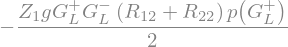

In [144]:
Ltest.factor()

In [145]:
print(Ltest.factor())

-Z1*g*{{G_L^+}}*{{G_L^-}}*(R_{12} + R_{22})*p({{G_L^+}})/2


$g*(R_{12} + R_{22})*p({{G_L^+}})/2$

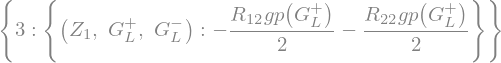

In [146]:
(extract_interaction_coefficients(
    L=Ltest, fields=set(scalar_fields + gauge_fields), parameters=parameters_
))

In [147]:
LagZ1 = (LHiggs_physical.expand().coeff(Z1)*Z1).expand()
#LagZ1

In [153]:
interactions_gauge_scalars = ((extract_interaction_coefficients(
    L=LHiggs_physical, fields=set(scalar_fields + gauge_fields), parameters=parameters_
)))

In [154]:
interactions_gauge_scalars.keys()

dict_keys([4, 3, 2, 1, 0])

In [155]:
set(scalar_fields + gauge_fields)

In [156]:
for interaction, coeff in interactions_gauge_scalars[3].items():
    print(interaction)
    print(coeff)

(A, A, {{H_2^0}})
R_{11}**2*\alpha_1*\rho_1*g**2*k_1**2*v_R/(\alpha_1**2*k_1**2 + 2*\alpha_1*\alpha_3*k_1**2 + \alpha_3**2*k_1**2 + 4*\rho_1**2*v_R**2) + R_{11}**2*\alpha_3*\rho_1*g**2*k_1**2*v_R/(\alpha_1**2*k_1**2 + 2*\alpha_1*\alpha_3*k_1**2 + \alpha_3**2*k_1**2 + 4*\rho_1**2*v_R**2) - 2*R_{11}*R_{21}*\alpha_1*\rho_1*g**2*k_1**2*v_R/(\alpha_1**2*k_1**2 + 2*\alpha_1*\alpha_3*k_1**2 + \alpha_3**2*k_1**2 + 4*\rho_1**2*v_R**2) - 2*R_{11}*R_{21}*\alpha_3*\rho_1*g**2*k_1**2*v_R/(\alpha_1**2*k_1**2 + 2*\alpha_1*\alpha_3*k_1**2 + \alpha_3**2*k_1**2 + 4*\rho_1**2*v_R**2) + R_{21}**2*\alpha_1*\rho_1*g**2*k_1**2*v_R/(\alpha_1**2*k_1**2 + 2*\alpha_1*\alpha_3*k_1**2 + \alpha_3**2*k_1**2 + 4*\rho_1**2*v_R**2) + R_{21}**2*\alpha_3*\rho_1*g**2*k_1**2*v_R/(\alpha_1**2*k_1**2 + 2*\alpha_1*\alpha_3*k_1**2 + \alpha_3**2*k_1**2 + 4*\rho_1**2*v_R**2) + 2*R_{21}**2*\rho_1**2*g**2*v_R**3/(\alpha_1**2*k_1**2 + 2*\alpha_1*\alpha_3*k_1**2 + \alpha_3**2*k_1**2 + 4*\rho_1**2*v_R**2) - 4*R_{21}*R_{31}*\rho_1**2*

In [157]:
#interactions_gauge_scalars = find_feynman_coefficients(
#    Lag=LHiggs_physical,
#    fields=set(fields),
#    parameters=parameters_,
#    momentum_function=momentum
#)

In [163]:
def test_feynman_coefficients(Lagrangian, fields, parameters):
    """ Test the Feynman coefficient extraction function by reconstructing the Lagrangian. """
    
    # Extract interactions
    interactions = extract_interaction_coefficients(Lagrangian, fields, parameters)
    
    # Reconstruct the Lagrangian from interactions
    reconstructed_Lagrangian = sum(
        coeff * Mul(*fields)
        for num_fields, terms in interactions.items()
        for fields, coeff in terms.items()
    )

    # Expand both the original and reconstructed Lagrangians
    expanded_original = Lagrangian.expand()
    expanded_reconstructed = reconstructed_Lagrangian

    print("\n--- Original Lagrangian ---")
    print(expanded_original)

    print("\n--- Reconstructed Lagrangian ---")
    print(expanded_reconstructed)

    # Check if they are equal
    diff = (expanded_original - expanded_reconstructed).expand().factor()
    if diff == 0 or diff.free_symbols.intersection(fields) == set():
        print("\n✅ Test Passed: The reconstructed Lagrangian matches the original!")
    else:
        print("\n❌ Test Failed: The reconstructed Lagrangian does NOT match the original.")

    return diff

In [164]:
lag_diff = test_feynman_coefficients(
    Lagrangian=LHiggs_physical,
    fields=set(fields),
    parameters=parameters_
)
#print(lag_diff)


--- Original Lagrangian ---
A**2*R_{11}**2*\alpha_1**2*\rho_1**2*g**2*k_1**2*v_R**2*{{H_2^0}}**2/(\alpha_1**4*k_1**4 + 4*\alpha_1**3*\alpha_3*k_1**4 + 6*\alpha_1**2*\alpha_3**2*k_1**4 + 8*\alpha_1**2*\rho_1**2*k_1**2*v_R**2 + 4*\alpha_1*\alpha_3**3*k_1**4 + 16*\alpha_1*\alpha_3*\rho_1**2*k_1**2*v_R**2 + \alpha_3**4*k_1**4 + 8*\alpha_3**2*\rho_1**2*k_1**2*v_R**2 + 16*\rho_1**4*v_R**4) + 2*A**2*R_{11}**2*\alpha_1*\alpha_3*\rho_1**2*g**2*k_1**2*v_R**2*{{H_2^0}}**2/(\alpha_1**4*k_1**4 + 4*\alpha_1**3*\alpha_3*k_1**4 + 6*\alpha_1**2*\alpha_3**2*k_1**4 + 8*\alpha_1**2*\rho_1**2*k_1**2*v_R**2 + 4*\alpha_1*\alpha_3**3*k_1**4 + 16*\alpha_1*\alpha_3*\rho_1**2*k_1**2*v_R**2 + \alpha_3**4*k_1**4 + 8*\alpha_3**2*\rho_1**2*k_1**2*v_R**2 + 16*\rho_1**4*v_R**4) + 4*A**2*R_{11}**2*\alpha_1*\rho_1**3*g**2*k_1*v_R**3*{{H_1^0}}*{{H_2^0}}/(\alpha_1**4*k_1**4 + 4*\alpha_1**3*\alpha_3*k_1**4 + 6*\alpha_1**2*\alpha_3**2*k_1**4 + 8*\alpha_1**2*\rho_1**2*k_1**2*v_R**2 + 4*\alpha_1*\alpha_3**3*k_1**4 + 16*\alph

In [165]:
print(lag_diff)

0


In [166]:
# Check if any coefficient still contains fields
for interaction, coeff in interactions_gauge_scalars[3].items():
    remaining_fields = coeff.free_symbols.intersection(set(scalar_fields + gauge_fields))
    print(interaction)
    print(f"Fields still in coefficient: {remaining_fields}")

(A, A, {{H_2^0}})
Fields still in coefficient: set()
(A, A, {{H_1^0}})
Fields still in coefficient: set()
(A, A, {{G_{Z_1}}})
Fields still in coefficient: set()
(A, A, {{A_1^0}})
Fields still in coefficient: set()
(A, A, {{H_3^0}})
Fields still in coefficient: set()
(A, A, {{A_2^0}})
Fields still in coefficient: set()
(A, A, {{H_4^0}})
Fields still in coefficient: set()
(A, A, {{G_{Z_2}}})
Fields still in coefficient: set()
(A, Z1, {{H_2^0}})
Fields still in coefficient: set()
(A, Z1, {{H_1^0}})
Fields still in coefficient: set()
(A, Z1, {{G_{Z_1}}})
Fields still in coefficient: set()
(A, Z1, {{A_1^0}})
Fields still in coefficient: set()
(A, Z1, {{H_3^0}})
Fields still in coefficient: set()
(A, Z1, {{A_2^0}})
Fields still in coefficient: set()
(A, Z1, {{H_4^0}})
Fields still in coefficient: set()
(A, Z2, {{H_2^0}})
Fields still in coefficient: set()
(A, Z2, {{H_1^0}})
Fields still in coefficient: set()
(A, Z2, {{G_{Z_1}}})
Fields still in coefficient: set()
(A, Z2, {{A_1^0}})
Fields st

### Interaction H10 WW

In [167]:
for interaction, coeff in interactions_gauge_scalars[3].items():
    if H10 in interaction:
        #display(interaction, coeff.factor())
        print(interaction)

(A, A, {{H_1^0}})
(A, Z1, {{H_1^0}})
(A, Z2, {{H_1^0}})
(Z1, Z1, {{H_1^0}})
(Z1, Z2, {{H_1^0}})
(Z2, Z2, {{H_1^0}})
(W_1^+, W_1^-, {{H_1^0}})
(W_1^+, W_2^-, {{H_1^0}})
(W_1^+, {{H_1^0}}, {{H_R^-}})
(W_1^+, {{G_R^-}}, {{H_1^0}})
(W_1^+, {{G_L^-}}, {{H_1^0}})
(W_1^-, W_2^+, {{H_1^0}})
(W_1^-, {{H_1^0}}, {{H_R^+}})
(W_1^-, {{G_R^+}}, {{H_1^0}})
(W_1^-, {{G_L^+}}, {{H_1^0}})
(W_2^+, W_2^-, {{H_1^0}})
(W_2^+, {{H_1^0}}, {{H_R^-}})
(W_2^+, {{G_R^-}}, {{H_1^0}})
(W_2^+, {{G_L^-}}, {{H_1^0}})
(W_2^-, {{H_1^0}}, {{H_R^+}})
(W_2^-, {{G_R^+}}, {{H_1^0}})
(W_2^-, {{G_L^+}}, {{H_1^0}})


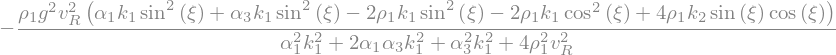

In [168]:
interactions_gauge_scalars[3][(W1p, W1m, H10)].factor()

In [169]:
interactionsH10_WW = [(W1p, W1m, H10), (W1p, W2m, H10), (W1m, W2p, H10), (W2p, W2m, H10)]

In [177]:
from sympy import fraction

def full_factor_vR(expr):
    """
    Factorizes both the numerator and denominator of a given expression.
    
    Parameters:
    expr (sympy expression): The input expression to be factorized.
    
    Returns:
    sympy expression: The fully factorized expression.
    """
    # Separate numerator and denominator
    numerator, denominator = fraction(expr)
    numerator = numerator.collect(vR, lambda x:x.factor(deep=True))
    denominator = denominator.collect(vR, lambda x:x.factor(deep=True))
    
    # Factorize both
    factored_expr = numerator / denominator
    
    return factored_expr

Interaction: 


Coefficient: 


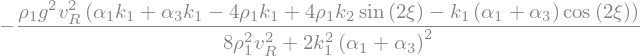

Coefficient approximation: 


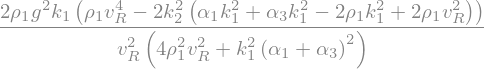

Interaction: 


Coefficient: 


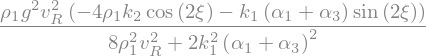

Coefficient approximation: 


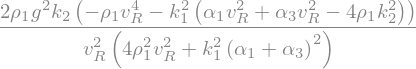

Interaction: 


Coefficient: 


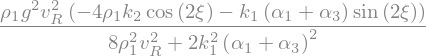

Coefficient approximation: 


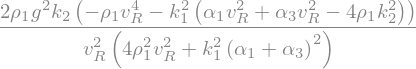

Interaction: 


Coefficient: 


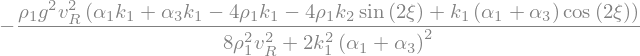

Coefficient approximation: 


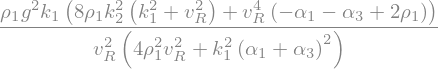

In [178]:
for interaction_tuple in interactionsH10_WW:
    coeff = interactions_gauge_scalars[3][interaction_tuple].factor()
    print('Interaction: ')
    display(Mul(*interaction_tuple))
    print('Coefficient: ')
    display(full_factor_vR(
        coeff.expand().collect([sin(xi), cos(xi)], factor).subs(
        sin(xi)**2,(1 - cos(2*xi)) / 2
        ).subs(
        cos(xi)**2,(1 + cos(2*xi)) / 2
        ).collect(cos(2*xi), lambda x:x.trigsimp()).collect([cos(2*xi), sin(2*xi)]).simplify()
    )
    )
    #display(coeff.trigsimp().factor())
    print('Coefficient approximation: ')
    display(
        full_factor_vR(
            coeff.subs(cos(xi),1).subs(sin(xi), tan2xi_sol[tan(2*xi)]/2).expand().collect(vR, factor).simplify()
        )
    )

In [173]:
from symbolic_tools import generate_latex_table_dict

In [174]:
def simplification_coeff(coeff):
    coeff_simplified = full_factor_vR(
        coeff.expand().collect([sin(xi), cos(xi)], factor).subs(
        sin(xi)**2,(1 - cos(2*xi)) / 2
        ).subs(
        cos(xi)**2,(1 + cos(2*xi)) / 2
        ).collect(cos(2*xi), lambda x:x.trigsimp()).collect([cos(2*xi), sin(2*xi)]).simplify()
    )
    numerator, denominator = fraction(coeff_simplified) 
    #return (1/denominator), numerator
    return Mul((1/denominator), numerator, evaluate=True)
    

def simplification_approx(coeff):
    coeff_simplified = full_factor_vR(
            coeff.subs(cos(xi),1).subs(sin(xi), tan2xi_sol[tan(2*xi)]/2).expand().collect(vR, factor).simplify()
        )
    numerator, denominator = fraction(coeff_simplified) 
    return Mul((1/denominator), numerator, evaluate=False)

In [175]:
interactionsH10_WW_dict = {interaction:interactions_gauge_scalars[3][interaction] for interaction in interactionsH10_WW}

In [176]:
print(generate_latex_table_dict(
    interactionsH10_WW_dict, 
    simplification_coeff=simplification_coeff,
    simplification_approx=simplification_approx
))

\begin{array}{|c|c|c|}
\hline
\textbf{Interaction} & \textbf{Coefficient} & \textbf{Simplified} \\
\hline
$W^{+}_{1} W^{-}_{1} {{H_1^0}}$ & $- \frac{\rho_{1} g^{2} v_{R}^{2} \left(\alpha_{1} k_{1} + \alpha_{3} k_{1} - 4 \rho_{1} k_{1} + 4 \rho_{1} k_{2} \sin{\left(2 \xi \right)} - k_{1} \left(\alpha_{1} + \alpha_{3}\right) \cos{\left(2 \xi \right)}\right)}{8 \rho_{1}^{2} v_{R}^{2} + 2 k_{1}^{2} \left(\alpha_{1} + \alpha_{3}\right)^{2}}$ & $\frac{1}{v_{R}^{2} \left(4 \rho_{1}^{2} v_{R}^{2} + k_{1}^{2} \left(\alpha_{1} + \alpha_{3}\right)^{2}\right)} 2 \rho_{1} g^{2} k_{1} \left(\rho_{1} v_{R}^{4} - 2 k_{2}^{2} \left(\alpha_{1} k_{1}^{2} + \alpha_{3} k_{1}^{2} - 2 \rho_{1} k_{1}^{2} + 2 \rho_{1} v_{R}^{2}\right)\right)$ \\ 
\hline
$W^{+}_{1} W^{-}_{2} {{H_1^0}}$ & $\frac{\rho_{1} g^{2} v_{R}^{2} \left(- 4 \rho_{1} k_{2} \cos{\left(2 \xi \right)} - k_{1} \left(\alpha_{1} + \alpha_{3}\right) \sin{\left(2 \xi \right)}\right)}{8 \rho_{1}^{2} v_{R}^{2} + 2 k_{1}^{2} \left(\alpha_{1} + \alpha_

### Interaction $H_1^0 W_1^+ S^-$

In [179]:
from potential_senjanovic_HiggsDoublets import GRp, GLp, HLp, HRp, GRm, GLm, HLm, HRm

In [193]:
interactionsH10_W1pSm = []
for S in [GLm, GRm, HLm, HRm, H10]:
    for S1 in [GLm, GRm, HLm, HRm, H10]:
        if (S1 == H10 or S == H10):
            interaction_tuple = (W1p, S, S1)
            if interaction_tuple not in interactionsH10_W1pSm:
                interactionsH10_W1pSm.append(interaction_tuple)

interactionsH10_W2pSm = []
for S in [GLm, GRm, HLm, HRm, H10]:
    for S1 in [GLm, GRm, HLm, HRm, H10]:
        if (S1 == H10 or S == H10):
            interaction_tuple = (W2p, S, S1)
            if interaction_tuple not in interactionsH10_W2pSm:
                interactionsH10_W2pSm.append(interaction_tuple)

In [194]:
interactionsH10_W1pSm_dict = {}
for interaction in interactionsH10_W1pSm:
    try:
        interactionsH10_W1pSm_dict[interaction] = interactions_gauge_scalars[3][interaction]
        print(f'interaction: {interaction}')
    except:
        print(f'This interaction is not present in this model: {interaction}')

interactionsH10_W2pSm_dict = {}
for interaction in interactionsH10_W2pSm:
    try:
        interactionsH10_W2pSm_dict[interaction] = interactions_gauge_scalars[3][interaction]
        print(f'interaction: {interaction}')
    except:
        print(f'This interaction is not present in this model: {interaction}')

interaction: (W_1^+, {{G_L^-}}, {{H_1^0}})
interaction: (W_1^+, {{G_R^-}}, {{H_1^0}})
This interaction is not present in this model: (W_1^+, {{H_L^-}}, {{H_1^0}})
This interaction is not present in this model: (W_1^+, {{H_R^-}}, {{H_1^0}})
This interaction is not present in this model: (W_1^+, {{H_1^0}}, {{G_L^-}})
This interaction is not present in this model: (W_1^+, {{H_1^0}}, {{G_R^-}})
This interaction is not present in this model: (W_1^+, {{H_1^0}}, {{H_L^-}})
interaction: (W_1^+, {{H_1^0}}, {{H_R^-}})
This interaction is not present in this model: (W_1^+, {{H_1^0}}, {{H_1^0}})
interaction: (W_2^+, {{G_L^-}}, {{H_1^0}})
interaction: (W_2^+, {{G_R^-}}, {{H_1^0}})
This interaction is not present in this model: (W_2^+, {{H_L^-}}, {{H_1^0}})
This interaction is not present in this model: (W_2^+, {{H_R^-}}, {{H_1^0}})
This interaction is not present in this model: (W_2^+, {{H_1^0}}, {{G_L^-}})
This interaction is not present in this model: (W_2^+, {{H_1^0}}, {{G_R^-}})
This interactio

Interaction: 


Coefficient: 


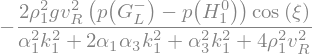

Interaction: 


Coefficient: 


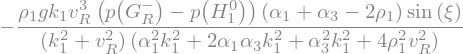

Interaction: 


Coefficient: 


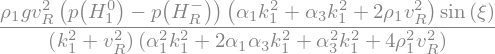

Interaction: 


Coefficient: 


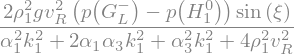

Interaction: 


Coefficient: 


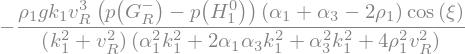

Interaction: 


Coefficient: 


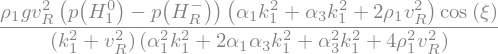

In [199]:
for interaction, coeff in interactionsH10_W1pSm_dict.items():
    print('Interaction: ')
    display(interaction)
    print('Coefficient: ')
    coeff_factor = coeff.factor()
    display(coeff_factor)
    interactionsH10_W1pSm_dict[interaction] = coeff_factor

for interaction, coeff in interactionsH10_W2pSm_dict.items():
    print('Interaction: ')
    display(interaction)
    print('Coefficient: ')
    coeff_factor = coeff.factor()
    display(coeff_factor)
    interactionsH10_W2pSm_dict[interaction] = coeff_factor

In [200]:
from symbolic_tools import generate_latex_table_dict_2col

In [201]:
print(generate_latex_table_dict_2col(interactionsH10_W1pSm_dict))

\begin{array}{|c|c|}
\hline
\textbf{Interaction} & \textbf{Coefficient} \\
\hline
$W^{+}_{1} {{G_L^-}} {{H_1^0}}$ & $- \frac{2 \rho_{1}^{2} g v_{R}^{2} \left(p{\left({{G_L^-}} \right)} - p{\left({{H_1^0}} \right)}\right) \cos{\left(\xi \right)}}{\alpha_{1}^{2} k_{1}^{2} + 2 \alpha_{1} \alpha_{3} k_{1}^{2} + \alpha_{3}^{2} k_{1}^{2} + 4 \rho_{1}^{2} v_{R}^{2}}$ \\ 
\hline
$W^{+}_{1} {{G_R^-}} {{H_1^0}}$ & $- \frac{\rho_{1} g k_{1} v_{R}^{3} \left(p{\left({{G_R^-}} \right)} - p{\left({{H_1^0}} \right)}\right) \left(\alpha_{1} + \alpha_{3} - 2 \rho_{1}\right) \sin{\left(\xi \right)}}{\left(k_{1}^{2} + v_{R}^{2}\right) \left(\alpha_{1}^{2} k_{1}^{2} + 2 \alpha_{1} \alpha_{3} k_{1}^{2} + \alpha_{3}^{2} k_{1}^{2} + 4 \rho_{1}^{2} v_{R}^{2}\right)}$ \\ 
\hline
$W^{+}_{1} {{H_1^0}} {{H_R^-}}$ & $\frac{\rho_{1} g v_{R}^{2} \left(p{\left({{H_1^0}} \right)} - p{\left({{H_R^-}} \right)}\right) \left(\alpha_{1} k_{1}^{2} + \alpha_{3} k_{1}^{2} + 2 \rho_{1} v_{R}^{2}\right) \sin{\left(\xi \right)}}{

In [202]:
print(generate_latex_table_dict_2col(interactionsH10_W2pSm_dict))

\begin{array}{|c|c|}
\hline
\textbf{Interaction} & \textbf{Coefficient} \\
\hline
$W^{+}_{2} {{G_L^-}} {{H_1^0}}$ & $\frac{2 \rho_{1}^{2} g v_{R}^{2} \left(p{\left({{G_L^-}} \right)} - p{\left({{H_1^0}} \right)}\right) \sin{\left(\xi \right)}}{\alpha_{1}^{2} k_{1}^{2} + 2 \alpha_{1} \alpha_{3} k_{1}^{2} + \alpha_{3}^{2} k_{1}^{2} + 4 \rho_{1}^{2} v_{R}^{2}}$ \\ 
\hline
$W^{+}_{2} {{G_R^-}} {{H_1^0}}$ & $- \frac{\rho_{1} g k_{1} v_{R}^{3} \left(p{\left({{G_R^-}} \right)} - p{\left({{H_1^0}} \right)}\right) \left(\alpha_{1} + \alpha_{3} - 2 \rho_{1}\right) \cos{\left(\xi \right)}}{\left(k_{1}^{2} + v_{R}^{2}\right) \left(\alpha_{1}^{2} k_{1}^{2} + 2 \alpha_{1} \alpha_{3} k_{1}^{2} + \alpha_{3}^{2} k_{1}^{2} + 4 \rho_{1}^{2} v_{R}^{2}\right)}$ \\ 
\hline
$W^{+}_{2} {{H_1^0}} {{H_R^-}}$ & $\frac{\rho_{1} g v_{R}^{2} \left(p{\left({{H_1^0}} \right)} - p{\left({{H_R^-}} \right)}\right) \left(\alpha_{1} k_{1}^{2} + \alpha_{3} k_{1}^{2} + 2 \rho_{1} v_{R}^{2}\right) \cos{\left(\xi \right)}}{\l

### Interaction Z SS

In [203]:
for interaction, coeff in interactions_gauge_scalars[3].items():
    if Z1 in interaction:
        print(interaction)

(A, Z1, {{H_2^0}})
(A, Z1, {{H_1^0}})
(A, Z1, {{G_{Z_1}}})
(A, Z1, {{A_1^0}})
(A, Z1, {{H_3^0}})
(A, Z1, {{A_2^0}})
(A, Z1, {{H_4^0}})
(A, Z1, {{G_{Z_2}}})
(Z1, Z1, {{H_2^0}})
(Z1, Z1, {{H_1^0}})
(Z1, Z1, {{G_{Z_1}}})
(Z1, Z1, {{A_1^0}})
(Z1, Z1, {{H_3^0}})
(Z1, Z1, {{A_2^0}})
(Z1, Z1, {{H_4^0}})
(Z1, Z2, {{H_2^0}})
(Z1, Z2, {{H_1^0}})
(Z1, Z2, {{G_{Z_1}}})
(Z1, Z2, {{A_1^0}})
(Z1, Z2, {{H_3^0}})
(Z1, Z2, {{A_2^0}})
(Z1, Z2, {{H_4^0}})
(W_1^+, Z1, {{G_R^-}})
(W_1^+, Z1, {{H_R^-}})
(W_1^+, Z1, {{G_L^-}})
(W_1^-, Z1, {{G_R^+}})
(W_1^-, Z1, {{H_R^+}})
(W_1^-, Z1, {{G_L^+}})
(W_2^+, Z1, {{G_R^-}})
(W_2^+, Z1, {{H_R^-}})
(W_2^+, Z1, {{G_L^-}})
(W_2^-, Z1, {{G_R^+}})
(W_2^-, Z1, {{H_R^+}})
(W_2^-, Z1, {{G_L^+}})
(Z1, {{G_R^+}}, {{G_R^-}})
(Z1, {{G_R^+}}, {{H_R^-}})
(Z1, {{G_R^-}}, {{H_R^+}})
(Z1, {{H_R^+}}, {{H_R^-}})
(Z1, {{G_L^+}}, {{G_L^-}})
(Z1, {{H_L^+}}, {{H_L^-}})
(Z1, Z1, {{G_{Z_2}}})
(Z1, Z2, {{G_{Z_2}}})
(W_1^+, Z1, {{H_L^-}})
(W_1^-, Z1, {{H_L^+}})
(W_2^+, Z1, {{H_L^-}})
(W_2^-, Z

In [204]:
interactionsZ1_VS = []
for Xp in [GRp, GLp, HLp, HRp, W1p, W2p]:
    for Xm in [GRm, GLm, HLm, HRm, W1m, W2m]:
        fields_tuple = tuple(sorted({Z1, Xp, Xm}, key=lambda x: str(x)))
        if fields_tuple not in interactionsZ1_VS:
            print(fields_tuple)
            interactionsZ1_VS.append(fields_tuple)

for Xp in [GRp, GLp, HLp, HRp]:
    for Xm in [GRm, GLm, HLm, HRm]:
        fields_tuple = tuple(sorted({Z1, partial_mu(Xp), Xm}, key=lambda x: str(x)))
        if fields_tuple not in interactionsZ1_VS:
            print(fields_tuple)
            interactionsZ1_VS.append(fields_tuple)

for Xp in [GRp, GLp, HLp, HRp]:
    for Xm in [GRm, GLm, HLm, HRm]:
        fields_tuple = tuple(sorted({Z1, Xp, partial_mu(Xm)}, key=lambda x: str(x)))
        if fields_tuple not in interactionsZ1_VS:
            print(fields_tuple)
            interactionsZ1_VS.append(fields_tuple)

(Z1, {{G_R^+}}, {{G_R^-}})
(Z1, {{G_L^-}}, {{G_R^+}})
(Z1, {{G_R^+}}, {{H_L^-}})
(Z1, {{G_R^+}}, {{H_R^-}})
(W_1^-, Z1, {{G_R^+}})
(W_2^-, Z1, {{G_R^+}})
(Z1, {{G_L^+}}, {{G_R^-}})
(Z1, {{G_L^+}}, {{G_L^-}})
(Z1, {{G_L^+}}, {{H_L^-}})
(Z1, {{G_L^+}}, {{H_R^-}})
(W_1^-, Z1, {{G_L^+}})
(W_2^-, Z1, {{G_L^+}})
(Z1, {{G_R^-}}, {{H_L^+}})
(Z1, {{G_L^-}}, {{H_L^+}})
(Z1, {{H_L^+}}, {{H_L^-}})
(Z1, {{H_L^+}}, {{H_R^-}})
(W_1^-, Z1, {{H_L^+}})
(W_2^-, Z1, {{H_L^+}})
(Z1, {{G_R^-}}, {{H_R^+}})
(Z1, {{G_L^-}}, {{H_R^+}})
(Z1, {{H_L^-}}, {{H_R^+}})
(Z1, {{H_R^+}}, {{H_R^-}})
(W_1^-, Z1, {{H_R^+}})
(W_2^-, Z1, {{H_R^+}})
(W_1^+, Z1, {{G_R^-}})
(W_1^+, Z1, {{G_L^-}})
(W_1^+, Z1, {{H_L^-}})
(W_1^+, Z1, {{H_R^-}})
(W_1^+, W_1^-, Z1)
(W_1^+, W_2^-, Z1)
(W_2^+, Z1, {{G_R^-}})
(W_2^+, Z1, {{G_L^-}})
(W_2^+, Z1, {{H_L^-}})
(W_2^+, Z1, {{H_R^-}})
(W_1^-, W_2^+, Z1)
(W_2^+, W_2^-, Z1)
(Z1, \partial_\mu({{G_R^+}}), {{G_R^-}})
(Z1, \partial_\mu({{G_R^+}}), {{G_L^-}})
(Z1, \partial_\mu({{G_R^+}}), {{H_L^-}})
(

In [205]:
interactionsZ1_VS_dict = {}
for interaction in interactionsZ1_VS:
    try:
        print(interaction)
        interactionsZ1_VS_dict[interaction] = interactions_gauge_scalars[3][interaction]
    except:
        print(f'Interaction {interaction} does not appear in this lagrangian')

(Z1, {{G_R^+}}, {{G_R^-}})
(Z1, {{G_L^-}}, {{G_R^+}})
Interaction (Z1, {{G_L^-}}, {{G_R^+}}) does not appear in this lagrangian
(Z1, {{G_R^+}}, {{H_L^-}})
Interaction (Z1, {{G_R^+}}, {{H_L^-}}) does not appear in this lagrangian
(Z1, {{G_R^+}}, {{H_R^-}})
(W_1^-, Z1, {{G_R^+}})
(W_2^-, Z1, {{G_R^+}})
(Z1, {{G_L^+}}, {{G_R^-}})
Interaction (Z1, {{G_L^+}}, {{G_R^-}}) does not appear in this lagrangian
(Z1, {{G_L^+}}, {{G_L^-}})
(Z1, {{G_L^+}}, {{H_L^-}})
Interaction (Z1, {{G_L^+}}, {{H_L^-}}) does not appear in this lagrangian
(Z1, {{G_L^+}}, {{H_R^-}})
Interaction (Z1, {{G_L^+}}, {{H_R^-}}) does not appear in this lagrangian
(W_1^-, Z1, {{G_L^+}})
(W_2^-, Z1, {{G_L^+}})
(Z1, {{G_R^-}}, {{H_L^+}})
Interaction (Z1, {{G_R^-}}, {{H_L^+}}) does not appear in this lagrangian
(Z1, {{G_L^-}}, {{H_L^+}})
Interaction (Z1, {{G_L^-}}, {{H_L^+}}) does not appear in this lagrangian
(Z1, {{H_L^+}}, {{H_L^-}})
(Z1, {{H_L^+}}, {{H_R^-}})
Interaction (Z1, {{H_L^+}}, {{H_R^-}}) does not appear in this lag

Interaction: 


Coeff: 


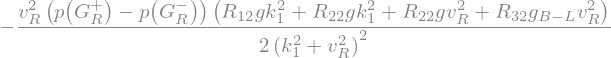

Interaction: 


Coeff: 


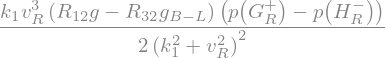

Interaction: 


Coeff: 


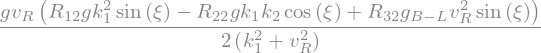

Interaction: 


Coeff: 


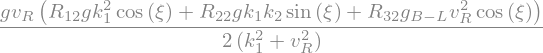

Interaction: 


Coeff: 


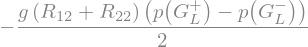

Interaction: 


Coeff: 


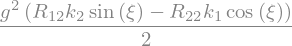

Interaction: 


Coeff: 


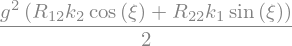

Interaction: 


Coeff: 


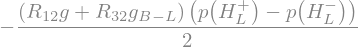

Interaction: 


Coeff: 


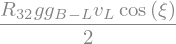

Interaction: 


Coeff: 


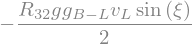

Interaction: 


Coeff: 


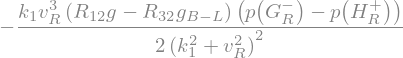

Interaction: 


Coeff: 


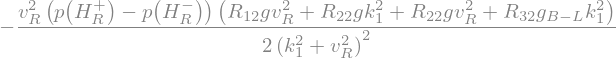

Interaction: 


Coeff: 


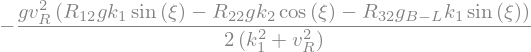

Interaction: 


Coeff: 


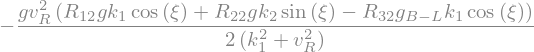

Interaction: 


Coeff: 


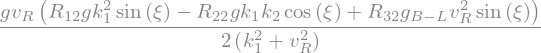

Interaction: 


Coeff: 


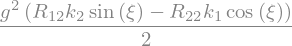

Interaction: 


Coeff: 


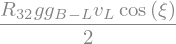

Interaction: 


Coeff: 


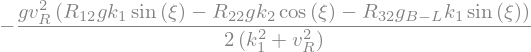

Interaction: 


Coeff: 


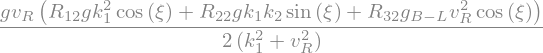

Interaction: 


Coeff: 


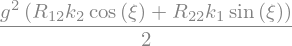

Interaction: 


Coeff: 


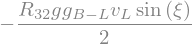

Interaction: 


Coeff: 


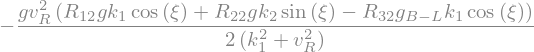

In [207]:
for interaction_tuple, coeff in interactionsZ1_VS_dict.items():
    print('Interaction: ')
    display(interaction_tuple)
    print('Coeff: ')
    coeff = coeff.subs(R13, 0).factor()
    display(coeff)
    #print('Approximation coeff: ')
    #coeff_approx = coeff.subs(sin(xi),tan2xi_sol[tan(2*xi)]/2).subs(cos(xi), 1).subs(
    #    sin(zeta),tan2zeta_sol_approx[tan(2*zeta)]/2
    #).subs(cos(zeta), 1).factor()
    #display(coeff_approx)

In [208]:
print(generate_latex_table_dict_2col(
    interactionsZ1_VS_dict, 
    simplification_coeff=lambda x:x.factor()
))

\begin{array}{|c|c|}
\hline
\textbf{Interaction} & \textbf{Coefficient} \\
\hline
$Z_{1} {{G_R^+}} {{G_R^-}}$ & $- \frac{v_{R}^{2} \left(p{\left({{G_R^+}} \right)} - p{\left({{G_R^-}} \right)}\right) \left(R_{12} g k_{1}^{2} + R_{22} g k_{1}^{2} + R_{22} g v_{R}^{2} + R_{32} g_{B-L} v_{R}^{2}\right)}{2 \left(k_{1}^{2} + v_{R}^{2}\right)^{2}}$ \\ 
\hline
$Z_{1} {{G_R^+}} {{H_R^-}}$ & $\frac{k_{1} v_{R}^{3} \left(R_{12} g - R_{32} g_{B-L}\right) \left(p{\left({{G_R^+}} \right)} - p{\left({{H_R^-}} \right)}\right)}{2 \left(k_{1}^{2} + v_{R}^{2}\right)^{2}}$ \\ 
\hline
$W^{-}_{1} Z_{1} {{G_R^+}}$ & $\frac{g v_{R} \left(R_{12} g k_{1}^{2} \sin{\left(\xi \right)} - R_{22} g k_{1} k_{2} \cos{\left(\xi \right)} + R_{32} g_{B-L} v_{R}^{2} \sin{\left(\xi \right)}\right)}{2 \left(k_{1}^{2} + v_{R}^{2}\right)}$ \\ 
\hline
$W^{-}_{2} Z_{1} {{G_R^+}}$ & $\frac{g v_{R} \left(R_{12} g k_{1}^{2} \cos{\left(\xi \right)} + R_{22} g k_{1} k_{2} \sin{\left(\xi \right)} + R_{32} g_{B-L} v_{R}^{2} \cos{\left

## Scalar potential interactions

### Interaction H10 SS

In [ ]:
from potential_senjanovic_HiggsDoublets import VLR_physical 

In [235]:
from sympy import conjugate

In [237]:
conjugate_scalar_fields = {
    conjugate(HLp): HLm,
    conjugate(HLm): HLp,
    conjugate(GLm): GLp,
    conjugate(GLp): GLm,
    conjugate(HRm): HRp,
    conjugate(HRp): HRm,
    conjugate(GRm): GRp,
    conjugate(GRp): GRm
}

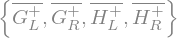

In [238]:
VLR_physical.atoms(Function)

In [239]:
VLR_physical = VLR_physical.subs(conjugate_scalar_fields).expand()

In [231]:
print(VLR_physical.coeff(H10).coeff(HRp).coeff(HRm))

0


In [211]:
fields

In [244]:
parameters_potential = (VLR_physical.free_symbols).difference(set(scalar_fields + gauge_fields))
parameters_potential

In [245]:
interactions_scalars = extract_interaction_coefficients(
    L=VLR_physical,
    fields=scalar_fields + gauge_fields,
    parameters=parameters_potential
)

In [246]:
for interaction, coeff in interactions_scalars[3].items():
    if H10 in interaction:
        print(interaction)

({{H_1^0}}, {{H_1^0}}, {{H_2^0}})
({{H_1^0}}, {{H_2^0}}, {{H_2^0}})
({{H_1^0}}, {{H_1^0}}, {{H_3^0}})
({{H_1^0}}, {{H_1^0}}, {{H_1^0}})
({{H_1^0}}, {{H_2^0}}, {{H_3^0}})
({{H_1^0}}, {{H_2^0}}, {{H_4^0}})
({{H_1^0}}, {{H_1^0}}, {{H_4^0}})
({{G_R^+}}, {{G_R^-}}, {{H_1^0}})
({{G_R^+}}, {{H_1^0}}, {{H_R^-}})
({{G_R^-}}, {{H_1^0}}, {{H_R^+}})
({{H_1^0}}, {{H_R^+}}, {{H_R^-}})
({{A_1^0}}, {{A_1^0}}, {{H_1^0}})
({{G_L^+}}, {{G_L^-}}, {{H_1^0}})
({{G_{Z_1}}}, {{G_{Z_1}}}, {{H_1^0}})
({{H_1^0}}, {{H_3^0}}, {{H_3^0}})
({{G_L^+}}, {{H_1^0}}, {{H_R^-}})
({{G_L^-}}, {{H_1^0}}, {{H_R^+}})
({{G_L^+}}, {{G_R^-}}, {{H_1^0}})
({{G_L^-}}, {{G_R^+}}, {{H_1^0}})
({{A_2^0}}, {{A_2^0}}, {{H_1^0}})
({{H_1^0}}, {{H_4^0}}, {{H_4^0}})
({{H_1^0}}, {{H_L^+}}, {{H_L^-}})
({{G_L^+}}, {{H_1^0}}, {{H_L^-}})
({{G_L^-}}, {{H_1^0}}, {{H_L^+}})
({{A_1^0}}, {{G_{Z_1}}}, {{H_1^0}})


In [247]:
interactionsH10_SS = []
for Xp in [GRp, GLp, HLp, HRp]:
    for Xm in [GRm, GLm, HLm, HRm]:
        fields = tuple(sorted({H10, Xp, Xm}, key=lambda x: str(x)))
        if fields not in interactionsH10_SS:
            print(fields)
            interactionsH10_SS.append(fields)

({{G_R^+}}, {{G_R^-}}, {{H_1^0}})
({{G_L^-}}, {{G_R^+}}, {{H_1^0}})
({{G_R^+}}, {{H_1^0}}, {{H_L^-}})
({{G_R^+}}, {{H_1^0}}, {{H_R^-}})
({{G_L^+}}, {{G_R^-}}, {{H_1^0}})
({{G_L^+}}, {{G_L^-}}, {{H_1^0}})
({{G_L^+}}, {{H_1^0}}, {{H_L^-}})
({{G_L^+}}, {{H_1^0}}, {{H_R^-}})
({{G_R^-}}, {{H_1^0}}, {{H_L^+}})
({{G_L^-}}, {{H_1^0}}, {{H_L^+}})
({{H_1^0}}, {{H_L^+}}, {{H_L^-}})
({{H_1^0}}, {{H_L^+}}, {{H_R^-}})
({{G_R^-}}, {{H_1^0}}, {{H_R^+}})
({{G_L^-}}, {{H_1^0}}, {{H_R^+}})
({{H_1^0}}, {{H_L^-}}, {{H_R^+}})
({{H_1^0}}, {{H_R^+}}, {{H_R^-}})


In [248]:
interactionsH10_SS_dict = {}
for interaction in interactionsH10_SS:
    try:
        interactionsH10_SS_dict[interaction] = interactions_scalars[3][interaction]
    except:
        print(f'Interaction {interaction} does not appear in this lagrangian')


Interaction ({{G_R^+}}, {{H_1^0}}, {{H_L^-}}) does not appear in this lagrangian
Interaction ({{G_R^-}}, {{H_1^0}}, {{H_L^+}}) does not appear in this lagrangian
Interaction ({{H_1^0}}, {{H_L^+}}, {{H_R^-}}) does not appear in this lagrangian
Interaction ({{H_1^0}}, {{H_L^-}}, {{H_R^+}}) does not appear in this lagrangian


In [251]:
from potential_senjanovic_HiggsDoublets import rho1
def factor_fraction_vR(expr):
    """
    Factorizes both the numerator and denominator of a given expression.
    
    Parameters:
    expr (sympy expression): The input expression to be factorized.
    
    Returns:
    sympy expression: The fully factorized expression.
    """
    # Separate numerator and denominator
    numerator, denominator = fraction(expr)
    numerator = numerator.collect(vR, lambda x:x.collect([rho1], lambda x:x.factor(deep=True)))
    denominator = denominator.collect(vR, lambda x:x.factor(deep=True))
    
    # Factorize both
    factored_expr = numerator / denominator
    
    return factored_expr

Interaction: 


Coefficient: 


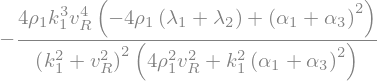

Interaction: 


Coefficient: 


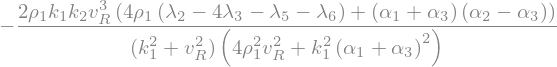

Interaction: 


Coefficient: 


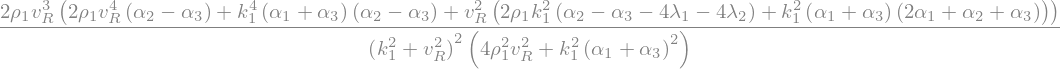

Interaction: 


Coefficient: 


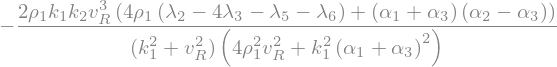

Interaction: 


Coefficient: 


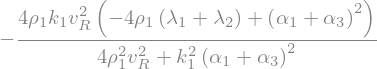

Interaction: 


Coefficient: 


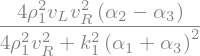

Interaction: 


Coefficient: 


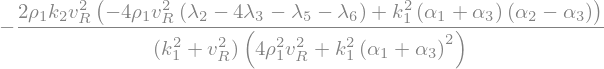

Interaction: 


Coefficient: 


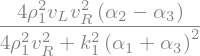

Interaction: 


Coefficient: 


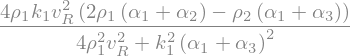

Interaction: 


Coefficient: 


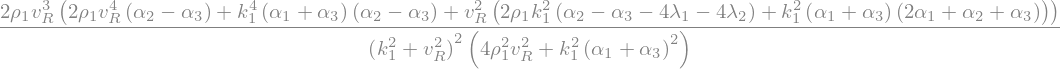

Interaction: 


Coefficient: 


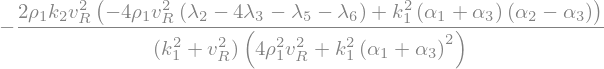

Interaction: 


Coefficient: 


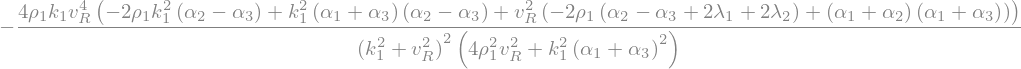

In [252]:
for interaction_tuple, coeff in interactionsH10_SS_dict.items():
    print('Interaction: ')
    display(Mul(*interaction_tuple))
    print('Coefficient: ')
    coeff_simplified = factor_fraction_vR(
            coeff.factor()
        )#.expand().collect(vR, lambda x:x.collect(rho1, factor))
    interactionsH10_SS_dict[interaction_tuple] = coeff_simplified
    display(coeff_simplified)
    #display(coeff.trigsimp().factor())
    #print('Coefficient approximation: ')
    #display(
    #    full_factor_vR(
    #        coeff.subs(cos(xi),1).subs(sin(xi), tan2xi_sol[tan(2*xi)]/2).expand().collect(vR, factor).simplify()
    #    )
    #)

In [253]:
print(
    generate_latex_table_dict_2col(
    interactions=interactionsH10_SS_dict
    )
)

\begin{array}{|c|c|}
\hline
\textbf{Interaction} & \textbf{Coefficient} \\
\hline
${{G_R^+}} {{G_R^-}} {{H_1^0}}$ & $- \frac{4 \rho_{1} k_{1}^{3} v_{R}^{4} \left(- 4 \rho_{1} \left(\lambda_{1} + \lambda_{2}\right) + \left(\alpha_{1} + \alpha_{3}\right)^{2}\right)}{\left(k_{1}^{2} + v_{R}^{2}\right)^{2} \left(4 \rho_{1}^{2} v_{R}^{2} + k_{1}^{2} \left(\alpha_{1} + \alpha_{3}\right)^{2}\right)}$ \\ 
\hline
${{G_L^-}} {{G_R^+}} {{H_1^0}}$ & $- \frac{2 \rho_{1} k_{1} k_{2} v_{R}^{3} \left(4 \rho_{1} \left(\lambda_{2} - 4 \lambda_{3} - \lambda_{5} - \lambda_{6}\right) + \left(\alpha_{1} + \alpha_{3}\right) \left(\alpha_{2} - \alpha_{3}\right)\right)}{\left(k_{1}^{2} + v_{R}^{2}\right) \left(4 \rho_{1}^{2} v_{R}^{2} + k_{1}^{2} \left(\alpha_{1} + \alpha_{3}\right)^{2}\right)}$ \\ 
\hline
${{G_R^+}} {{H_1^0}} {{H_R^-}}$ & $\frac{2 \rho_{1} v_{R}^{3} \left(2 \rho_{1} v_{R}^{4} \left(\alpha_{2} - \alpha_{3}\right) + k_{1}^{4} \left(\alpha_{1} + \alpha_{3}\right) \left(\alpha_{2} - \alpha_{3}\ri

# Yukawa lepton sector

$$\mathcal{L}\supset-\overline{L}_{iR}Y_{ij}\Phi^{\dagger}L_{jL}-\overline{L}_{iR}\tilde{Y}_{ij}\tilde{\Phi}^{\dagger}L_{jL}-\overline{S}_{i}Y_{ijL}\tilde{\chi}_{L}L_{ijL}-\overline{S}_{i}^{c}Y_{ijR}\tilde{\chi}_{R}L_{jR}-\frac{1}{2}\overline{S}_{i}^{c}\mu_{ij}S_{j}+\text{h.c.}$$

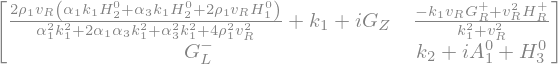

In [341]:
Phi = Phi.subs(conjugate_fields)
Phi

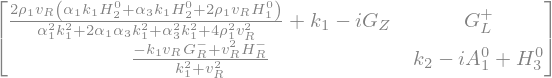

In [342]:
PhiDagger = PhiDagger.subs(complex_scalar_fields).subs(change_scalar_fields).subs(conjugate_fields)
PhiDagger